<h1 style="text-align:center"> Stack Overflow: Tag Prediction </h1>

<img src='../images/so_tag/pic1.jpg'/>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from pathlib import Path

<p style='font-size:24px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:14px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h2> Data </h2>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h2> Mapping to a Machine Learning Problem </h2>



<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3> Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

## Read the data file

In [2]:
path = Path('../data/so_tag')
list(path.iterdir())

[PosixPath('../data/so_tag/._lr_with_more_title_weight.pkl'),
 PosixPath('../data/so_tag/OpenedFilesView.exe'),
 PosixPath('../data/so_tag/Test.csv'),
 PosixPath('../data/so_tag/tokenaizer.JPG'),
 PosixPath('../data/so_tag/._Titlemoreweight.db'),
 PosixPath('../data/so_tag/._tokenaizer.JPG'),
 PosixPath('../data/so_tag/._train_no_dup-003.db'),
 PosixPath('../data/so_tag/._SO_Tag_Predictor.ipynb'),
 PosixPath('../data/so_tag/._lr_with_equal_weight-002.pkl'),
 PosixPath('../data/so_tag/._Processed.db'),
 PosixPath('../data/so_tag/Processed.db'),
 PosixPath('../data/so_tag/lr_with_equal_weight-002.pkl'),
 PosixPath('../data/so_tag/SO_Tag_Predictor.ipynb'),
 PosixPath('../data/so_tag/SampleSubmission.csv'),
 PosixPath('../data/so_tag/lr_with_more_title_weight.pkl'),
 PosixPath('../data/so_tag/Titlemoreweight.db'),
 PosixPath('../data/so_tag/._tag_counts_dict_dtm.csv'),
 PosixPath('../data/so_tag/Train.csv'),
 PosixPath('../data/so_tag/.ipynb_checkpoints'),
 PosixPath('../data/so_tag/tag_co

In [3]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 200000
    j = 0
    index = 1
    for df in pd.read_csv(path/'Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index
        j += 1
        df.to_sql('data', disk_engine, if_exists='append')
        index = df.index[-1] + 1
    end = datetime.now()
    print(f'Time take to create db:: {end - start}')

In [4]:
start = datetime.now()
con = sqlite3.connect('train.db')
rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print(f"Number of rows in the db:: {(rows['count(*)'].values[0])}")
con.close()
end = datetime.now()
print(f'Time take to create db:: {end - start}')

Number of rows in the db:: 6034196
Time take to create db:: 0:00:00.055394


## Check for duplicates

In [5]:
start = datetime.now()
con = sqlite3.connect('train.db')
df_duplicates = pd.read_sql_query('SELECT title, body, tags, COUNT(*) as cnt_dup FROM data GROUP BY title, body, tags', con)
con.close()
print("Time taken to run this cell :", datetime.now() - start)



Time taken to run this cell : 0:01:05.739780


In [6]:
df_duplicates.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [7]:
df_duplicates.shape

(4206315, 4)

In [8]:
print(f"Total duplicate rows {((rows['count(*)'].values[0] - df_duplicates.shape[0]) / rows['count(*)'].values[0]) * 100}")



Total duplicate rows 30.292038906260256


In [9]:
df_duplicates.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [10]:
df_duplicates[df_duplicates['Tags'].isnull()]

,Title,Body,Tags,cnt_dup
777547,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,None,1
962680,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,None,1
1126558,Handle NullObjects,<p>I have done quite a bit of research on best...,None,1
1256102,How do Germans call null,"<p>In german null means 0, so how do they call...",None,1
2430668,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,None,1
3329908,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",None,1
3551595,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,None,2


In [11]:
df_duplicates['Tags'].fillna('', inplace=True)

In [12]:
start = datetime.now()
df_duplicates['tags_count'] = df_duplicates['Tags'].apply(lambda x: len(x.split(' ')))
end = datetime.now()
print(f'Time take to create db:: {end - start}')
df_duplicates.head()

Time take to create db:: 0:00:02.447201


,Title,Body,Tags,cnt_dup,tags_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [54]:
# if not os.path.isfile(path/'train_no_dup.db'):
#     disk_dup = create_engine("sqlite:///train_no_dup.db")
#     no_dup = pd.DataFrame(df_duplicates, columns=['Title', 'Body', 'Tags'])
#     no_dup.to_sql('no_dup_train',disk_dup)

In [13]:
start = datetime.now()
con = sqlite3.connect('train_no_dup.db')
tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
#Always remember to close the database
con.close()

# Let's now drop unwanted column.
tag_data.drop(tag_data.index[0], inplace=True)
#Printing first 5 columns from our data frame
tag_data.head()
end = datetime.now()
print(f'Time take to create db:: {end - start}')

Time take to create db:: 0:00:06.506556


In [14]:
df_duplicates[df_duplicates.Tags.isnull()]

,Title,Body,Tags,cnt_dup,tags_count


In [56]:
df_duplicates[df_duplicates.tags_count == 0]

,Title,Body,Tags,cnt_dup,tags_count


## Analysis of Tags

In [15]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
tags_dtm = vectorizer.fit_transform(df_duplicates.Tags)

In [16]:
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### Number of times a tag appeared

In [17]:
freqs = tags_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [18]:
import gc; gc.collect()

7

In [19]:
if not os.path.isfile(path/'tag_counts_dict_dtm.csv'):
    with open(path/'tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
                writer.writerow([key, value])
tag_df = pd.read_csv(path/"tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [20]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted.Counts.values

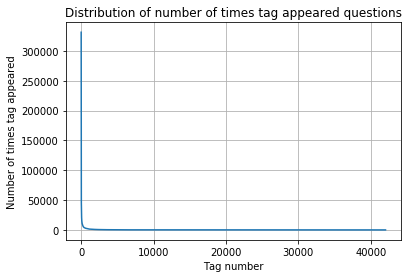

In [21]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

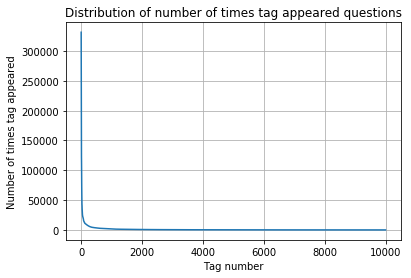

In [22]:
plt.plot(tag_counts[:10000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

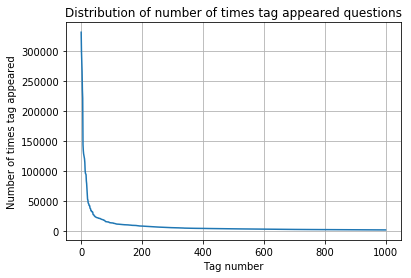

In [24]:
plt.plot(tag_counts[:1000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

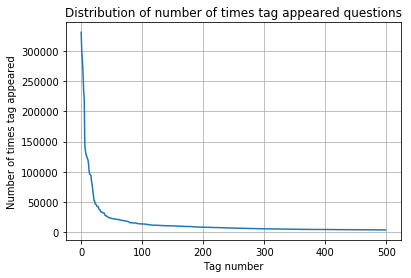

In [25]:
plt.plot(tag_counts[:500])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

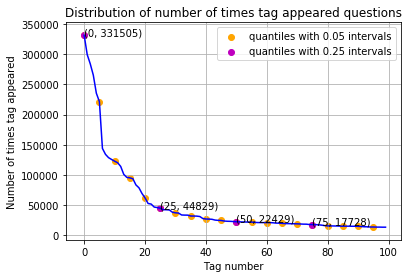

In [33]:
plt.plot(tag_counts[:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label="quantiles with 0.25 intervals")

for x, y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s=f'({x}, {y})', xy=(x, y))


plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [34]:
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags

print (f'{len(lst_tags_gt_10k)} Tags are used more than 10000 times')
print (f'{len(lst_tags_gt_100k)} Tags are used more than 100000 times')

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


In [42]:
 tag_df[tag_df.Counts==tag_df.Counts.max()]

,Tags,Counts
4337,c#,331505


In [43]:
 tag_df[tag_df.Counts==tag_df.Counts.min()]

,Tags,Counts
2,.asp.net-mvc,1
8,.drv,1
13,.exe.config,1
35,.net-bugs,1
38,.net-compact,1
63,.sbr,1
66,.sys,1
72,10.8,1
79,12.04,1
90,2-3-tree,1


## Tags Per Question 

In [51]:
tag_quest_count = tags_dtm.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]

print (f'We have total {len(tag_quest_count)} datapoints.')

print(tag_quest_count[:5])

We have total 4206315 datapoints.
[2, 3, 4, 2, 2]


In [55]:
print (f'Maximum number of tags per question:: {np.max(tag_quest_count)}')
print (f'Minimum number of tags per question:: {np.min(tag_quest_count)}')
print (f'Average number of tags per question:: {np.mean(tag_quest_count)}')

Maximum number of tags per question:: 5
Minimum number of tags per question:: 0
Average number of tags per question:: 2.899437631275832


In [63]:
np.array(tag_quest_count)[np.array(tag_quest_count) == 0]

array([0, 0, 0, 0, 0, 0, 0])

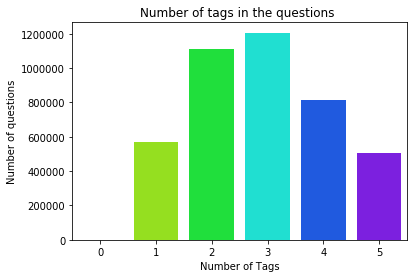

In [64]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

## Most Frequent Tags 


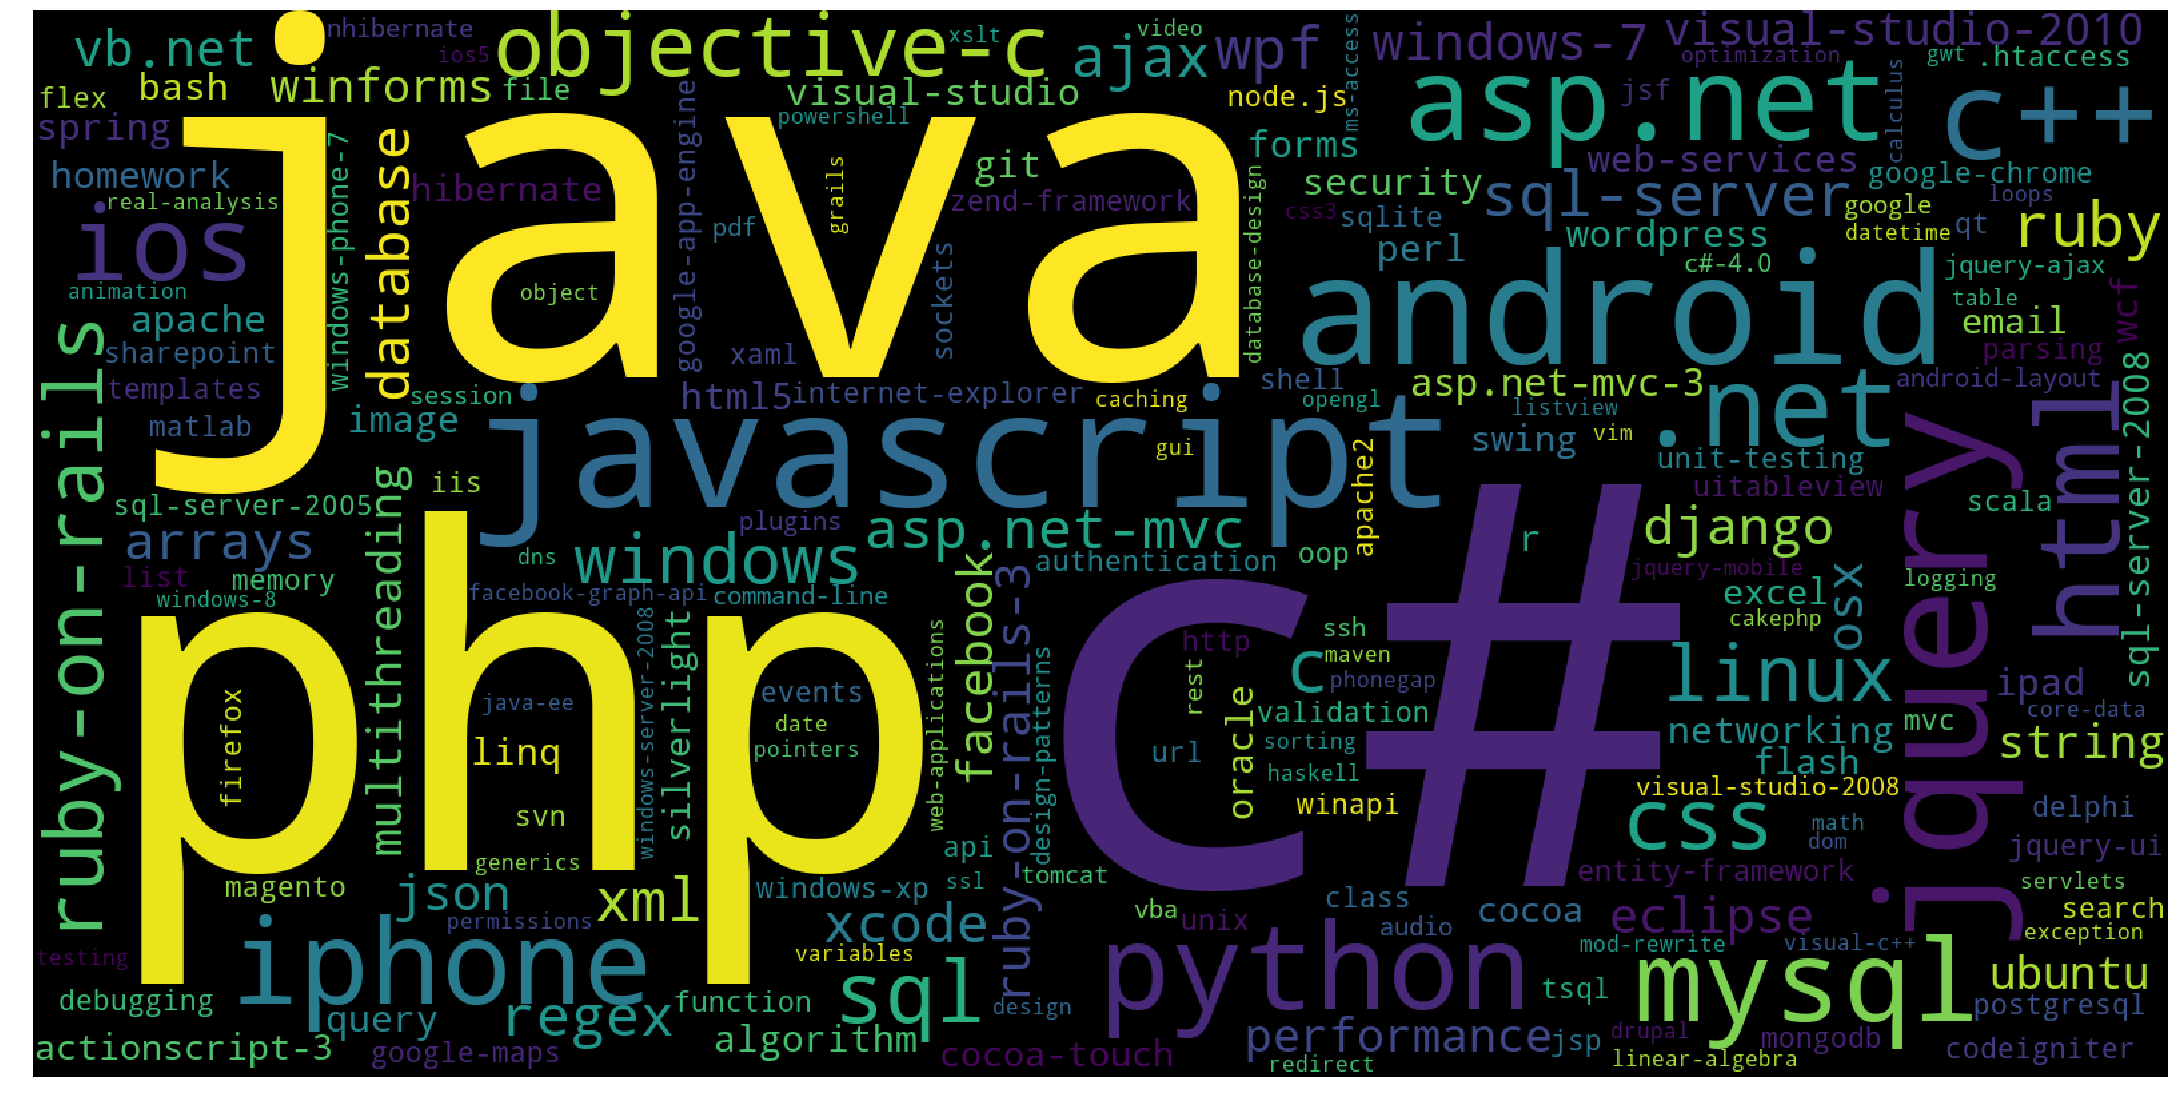

Time take to create db:: 0:00:02.821913


In [65]:
start = datetime.now()

tup = dict(result.items())
wordcloud = WordCloud(background_color='black', width=1600, height=800).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

end = datetime.now()
print(f'Time take to create db:: {end - start}')

## The top 20 tags 

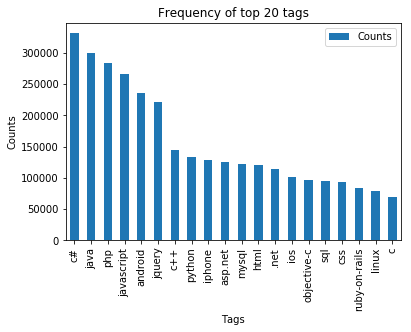

In [66]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

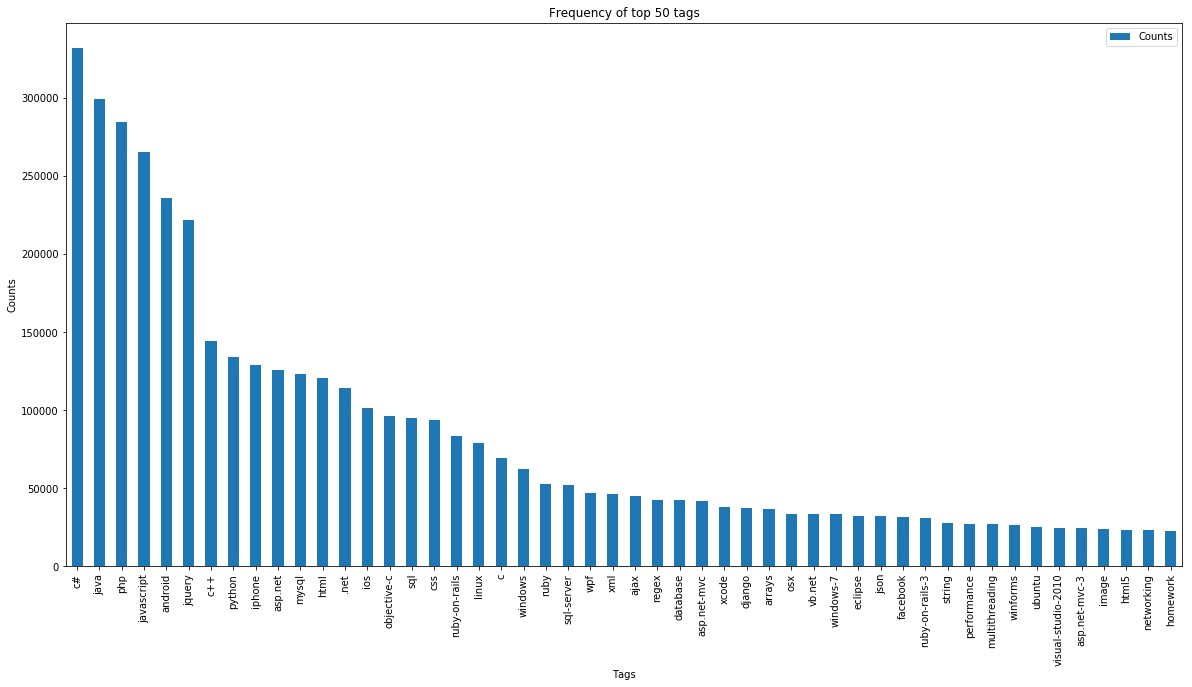

In [71]:
i=np.arange(50)
tag_df_sorted.head(50).plot(kind='bar', figsize=(20, 10))
plt.title('Frequency of top 50 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<h3> Cleaning and preprocessing of Questions </h3>

<h3> Preprocessing </h3>

In [74]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [75]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    name = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(name)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [76]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = path/'train_no_dup.db'
write_db = path/'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:02:47.863853


__create a new data base to store the sampled and preprocessed questions__

In [79]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]
    
    if '<code>' in question:
        questions_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1170
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:17:41.719326


In [80]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [81]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('error updat work test blog updat someth went wrong think updat finish updat enabl new theme function file made sinc updat went wrong access admin area error front end work fine blog theme work without problem local machin delet file server except upload updat new version avail solut problem',)
----------------------------------------------------------------------------------------------------
('want look ad group sid without use samaccountnam directoryservic accountmanag question c way look activ directori group sid without use librari icki ugli ldap updat ask attribut under check ad legaci identifi microsoft suggest avoid check role also control ad ensur samaccountnam remain sync user friend name request setup reason issu came first place pass plural name rather singular samaccountnam string valu also samaccountnam sid may chang exampl ad admin delet account creat sid sure differ samaccountnam anoth spot human error alway restor name upn valu request eve

In [85]:
#Taking 1 Million entries to a dataframe.
write_db = path/'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [86]:
preprocessed_data.head()

,question,tags
0,way set scope requir explicit global look way ...,php
1,error updat work test blog updat someth went w...,errors update 500-internal-error
2,want look ad group sid without use samaccountn...,c# asp.net-mvc authentication active-directory...
3,sort number though word rubi default sort numb...,ruby sorting
4,hibern one databas sql queri think understand ...,java sql hibernate orm


In [87]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


## Machine Learning Models

<h2> Converting tags for multilabel problems </h2>

In [88]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__We will sample the number of tags instead considering all of them (due to limitation of computing power)__

In [90]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn


def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [91]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs - questions_explained_fn(i)) / total_qs) * 100, 2))

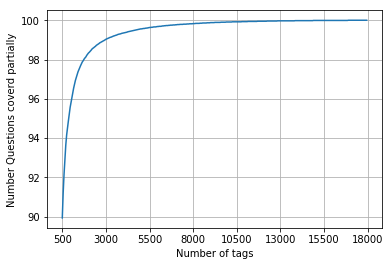

with  5500 tags we are covering  99.03 % of questions


In [92]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")



In [93]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

number of questions that are not covered : 9715 out of  999999
Number of tags in sample : 35431
number of tags taken : 5500 ( 15.523129462899721 %)


__We consider top 15% tags which covers  99% of the questions__

<h2> Split the data into test and train </h2>

In [95]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [96]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


## Featurizing data

In [97]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:17.777249


In [100]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799999, 88204) Y : (799999, 5500)
Dimensions of test data X: (200000, 88204) Y: (200000, 5500)


<h2> Applying Logistic Regression with OneVsRest Classifier </h2>

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
end = datetime.now()
print(f"Time taken to run this cell :: {end - start}")

In [ ]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

<h3> Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h3>

In [ ]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

<h3> Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [ ]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)


# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__Sample quesitons after preprocessing of data__

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

__Saving Preprocessed data to a Database__

In [ ]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

In [ ]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__Selecting 500 Tags__

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
    
    
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [ ]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

In [ ]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [ ]:
<h3> Featurizing data with TfIdf vectorizer </h3>